# Text classification with an RNN

In this lab exercise, we will learn how to use a Recurrent Neural Network (LSTM) to perform text classification. We will use a dataset of programming questions from Stack Overflow. Each question ("How do I sort a dictionary by value?") is labeled with exactly one tag (`Python`, `CSharp`, `JavaScript`, or `Java`). Your task is to develop a model that predicts the tag for a question. This is an example of multi-class classification. 

At the end of the exercise, you should be able to: 

- use tf.data to load text data 
- encode text data into vectors suitable training a deep learning model
- build a model using LSTM (bidirectional) 
- evaluate the performance of the model


## Setup

In [69]:
import numpy as np

import pathlib

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Download and explore the dataset


Next, you will download the dataset, and explore the directory structure.

In [126]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

# dataset_fpath contains the full path of the downloaded file
dataset_fpath = utils.get_file(
    'stack_overflow_16k.tar.gz',
    data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')

# to get the parent directory of the downloaded file 
dataset_dir = pathlib.Path(dataset_fpath).parent

print(dataset_dir)

6053888/6053168 [==============================] - 0s 0us/step
/tmp/.keras


In [127]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/.DS_Store'),
 PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/README.md'),
 PosixPath('/tmp/.keras/train'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz.tar.gz')]

In [128]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/.DS_Store'),
 PosixPath('/tmp/.keras/train/python'),
 PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/javascript')]

In [129]:
train_dir2 = dataset_dir/'train'/'python'
list(train_dir2.iterdir())[:20]

[PosixPath('/tmp/.keras/train/python/1053.txt'),
 PosixPath('/tmp/.keras/train/python/1735.txt'),
 PosixPath('/tmp/.keras/train/python/2228.txt'),
 PosixPath('/tmp/.keras/train/python/1721.txt'),
 PosixPath('/tmp/.keras/train/python/1047.txt'),
 PosixPath('/tmp/.keras/train/python/2566.txt'),
 PosixPath('/tmp/.keras/train/python/2200.txt'),
 PosixPath('/tmp/.keras/train/python/1709.txt'),
 PosixPath('/tmp/.keras/train/python/289.txt'),
 PosixPath('/tmp/.keras/train/python/2214.txt'),
 PosixPath('/tmp/.keras/train/python/2572.txt'),
 PosixPath('/tmp/.keras/train/python/504.txt'),
 PosixPath('/tmp/.keras/train/python/1090.txt'),
 PosixPath('/tmp/.keras/train/python/2599.txt'),
 PosixPath('/tmp/.keras/train/python/262.txt'),
 PosixPath('/tmp/.keras/train/python/276.txt'),
 PosixPath('/tmp/.keras/train/python/1084.txt'),
 PosixPath('/tmp/.keras/train/python/510.txt'),
 PosixPath('/tmp/.keras/train/python/538.txt'),
 PosixPath('/tmp/.keras/train/python/1912.txt')]

In [130]:
sample_file = train_dir/'python/1735.txt'
with open(sample_file) as f:
  print(f.read())

"blank bins every 20 minutes i have a time field that goes from 07:00 to 21:00. i want to make bins of 20 minutes, is there something like this in blank:..07:00 - 07:20.07:20 - 07:40.07:40 - 08:00.08:00 - 08:20.08:20 - 08:40.08:40 - 09:00.09:00 - 09:20.09:20 - 09:40.09:40 - 10:00"



### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility to create a labeled `tf.data.Dataset`. If you're new to [tf.data](https://www.tensorflow.org/guide/data), it's a powerful collection of tools for building input pipelines.

The `preprocessing.text_dataset_from_directory` expects a directory structure as follows.

```
train/
...csharp/
......1.txt
......2.txt
...java/
......1.txt
......2.txt
...javascript/
......1.txt
......2.txt
...python/
......1.txt
......2.txt
```

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). The Stack Overflow dataset has already been divided into train and test, but it lacks a validation set. Create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [131]:
batch_size = 32
seed = 42

raw_train_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 12000 files belonging to 4 classes.
Using 9600 files for training.


The labels are `0`, `1`, `2` or `3`. To see which of these correspond to which string label, you can check the `class_names` property on the dataset.


In [132]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Next, you will create a validation and test dataset. You will use the remaining 1,600 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [133]:
raw_val_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 12000 files belonging to 4 classes.
Using 2400 files for validation.


In [134]:
test_dir = dataset_dir/'test'
raw_test_ds = preprocessing.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

Found 4000 files belonging to 4 classes.


### Prepare the dataset for training

Note: The Preprocessing APIs used in this section are experimental in TensorFlow 2.3 and subject to change.

Next, you will standardize, tokenize, and vectorize the data using the `preprocessing.TextVectorization` layer.
* Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.

* Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words by splitting on whitespace).

* Vectorization refers to converting tokens into numbers so they can be fed into a neural network.

All of these tasks can be accomplished with this layer. You can learn more about each of these in the [API doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

* The default standardization converts text to lowercase and removes punctuation.

* The default tokenizer splits on whitespace.

* The default vectorization mode is `int`. This outputs integer indices (one per token). This mode can be used to build models that take word order into account. You can also use other modes, like `binary`, to build bag-of-word models.


You will build two modes to learn more about these. First, you will use the `binary` model to build a bag-of-words model. Next, you will use the `int` mode with a 1D ConvNet.

For `int` mode, in addition to maximum vocabulary size, you need to set an explicit maximum sequence length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [135]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [136]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda text, labels: text)
int_vectorize_layer.adapt(train_text)

See the result of using these layers to preprocess data:

In [137]:
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [138]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", first_label)

Question tf.Tensor(b'"out of memory exception while reading large excel sheet in blank i am trying to upload excel sheet of 10000 records and 29 columns but giving me out of memory error, to solve this in increase memory size in eclipe.ini file but no use. i decrease columns upto 4 then it doesn\'t give me error. but for more columns error is coming . here with attached screenshot of errorenter image description here"\n', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int32)


In [139]:
print("'int' vectorized question:",
      int_vectorize_text(first_question, first_label)[0])

'int' vectorized question: tf.Tensor(
[[  94    9  607  184  105  448  818 1024 2260    7   16    3   36   84
     4 1386 1024 2260    9 1517 1173    8 1934  746   26  688   74   94
     9  607   65    4  459   13    7 1550  607  285    7    1   39   26
   129   70    3 4565  746 3573  145   85   10  180  355   74   65   26
    12  174  746   65    6 1097   98   21 1746 2807    9    1  223  689
    98    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0

As you can see above, `binary` mode returns an array denoting which tokens exist at least once in the input, while `int` mode replaces each token by an integer, thus preserving their order. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [140]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  scan
313 --->  command
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the `TextVectorization` layers you created earlier to the train, validation, and test dataset.

In [141]:
int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

You are nearly ready to train your model. As a final preprocessing step, you will apply the `TextVectorization` layers you created earlier to the train, validation, and test dataset.

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

Note that tf.data.AUTOTUNE is only available in Tensorflow v2.4 onwards.

In [142]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [143]:
int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

## Create the model

![A drawing of the information flow in the model](images/bidirectional_rnn.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [150]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [151]:
print([layer.supports_masking for layer in model.layers])

[True, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

Compile the Keras model to configure the training process:

In [152]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(int_train_ds, validation_data=int_val_ds, validation_steps=30, epochs=10)

Epoch 1/10
300/300 [==============================] - 41s 120ms/step - loss: 1.3223 - accuracy: 0.3234 - val_loss: 0.9946 - val_accuracy: 0.5938
Epoch 2/10
300/300 [==============================] - 36s 118ms/step - loss: 0.8514 - accuracy: 0.6549 - val_loss: 0.7349 - val_accuracy: 0.7104
Epoch 3/10
300/300 [==============================] - 38s 126ms/step - loss: 0.5954 - accuracy: 0.7809 - val_loss: 0.6082 - val_accuracy: 0.7698
Epoch 4/10
300/300 [==============================] - 35s 117ms/step - loss: 0.3972 - accuracy: 0.8713 - val_loss: 0.5959 - val_accuracy: 0.8042
Epoch 5/10
300/300 [==============================] - 43s 142ms/step - loss: 0.3163 - accuracy: 0.9047 - val_loss: 0.7278 - val_accuracy: 0.7917
Epoch 6/10
300/300 [==============================] - 43s 143ms/step - loss: 0.2547 - accuracy: 0.9251 - val_loss: 0.6805 - val_accuracy: 0.7885
Epoch 7/10
300/300 [==============================] - 41s 135ms/step - loss: 0.1831 - accuracy: 0.9465 - val_loss: 0.7231 - val_ac

## test_loss, test_acc = model.evaluate(int_test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

(0, 1.2962011510506273)

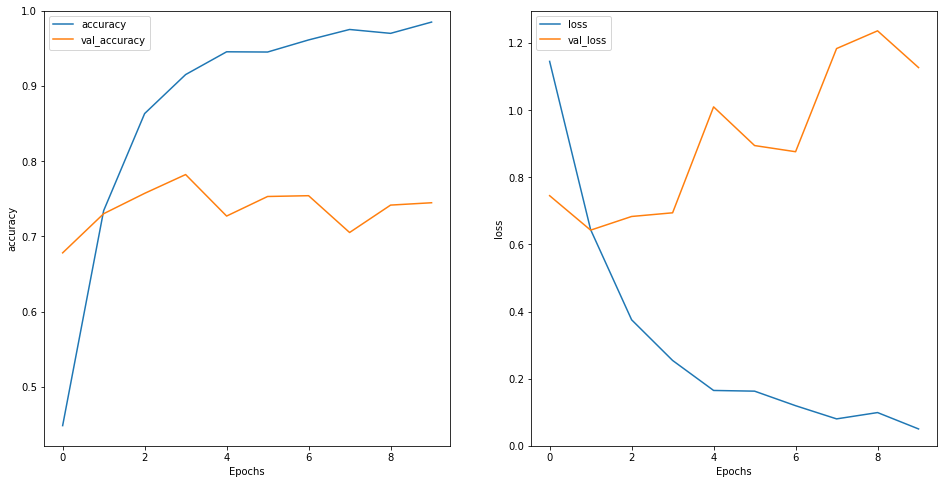

In [108]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

### Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [112]:
export_model = tf.keras.Sequential(
    [int_vectorize_layer, model,
     tf.keras.layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(accuracy))

250/250 [==============================] - 12s 25ms/step - loss: 0.9845 - accuracy: 0.7550
Accuracy: 74.79%


Now your model can take raw strings as input and predict a score for each label using `model.predict`. Define a function to find the label with the maximum score:

In [113]:
def get_string_labels(predicted_scores_batch):
  predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
  predicted_labels = tf.gather(raw_train_ds.class_names, predicted_int_labels)
  return predicted_labels

### Run inference on new data

In [114]:
inputs = [
    "how do I extract keys from a dict into a list?",  # python
    "debug public static void main(string[] args) {...}",  # java
]
predicted_scores = export_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

Question:  how do I extract keys from a dict into a list?
Predicted label:  b'python'
Question:  debug public static void main(string[] args) {...}
Predicted label:  b'java'


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your `TextVectorization` layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:


![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4)
])

In [120]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [121]:
history = model.fit(int_train_ds, epochs=10,
                    validation_data=int_val_ds,
                    validation_steps=30)

Epoch 1/10
200/200 [==============================] - 57s 243ms/step - loss: 1.3284 - accuracy: 0.3157 - val_loss: 0.9884 - val_accuracy: 0.5688
Epoch 2/10
200/200 [==============================] - 44s 221ms/step - loss: 0.9305 - accuracy: 0.5927 - val_loss: 0.7304 - val_accuracy: 0.6917
Epoch 3/10
200/200 [==============================] - 44s 220ms/step - loss: 0.7076 - accuracy: 0.6980 - val_loss: 0.7031 - val_accuracy: 0.7531
Epoch 4/10
200/200 [==============================] - 44s 222ms/step - loss: 0.5173 - accuracy: 0.8107 - val_loss: 0.6940 - val_accuracy: 0.7490
Epoch 5/10
200/200 [==============================] - 44s 222ms/step - loss: 0.3796 - accuracy: 0.8778 - val_loss: 0.7519 - val_accuracy: 0.7375
Epoch 6/10
200/200 [==============================] - 45s 226ms/step - loss: 0.3448 - accuracy: 0.8912 - val_loss: 0.8511 - val_accuracy: 0.7302
Epoch 7/10
200/200 [==============================] - 45s 227ms/step - loss: 0.2668 - accuracy: 0.9197 - val_loss: 0.9052 - val_ac

In [26]:
test_loss, test_acc = model.evaluate(int_test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 26s 64ms/step - loss: 0.3155 - accuracy: 0.8551
Test Loss: 0.315508097410202
Test Accuracy: 0.8550800085067749


In [122]:
export_model = tf.keras.Sequential(
    [int_vectorize_layer, model,
     tf.keras.layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [124]:
# predict on a sample text without padding.
inputs = [
    "how do I extract keys from a dict into a list?",  # python
    "debug public static void main(string[] args) {...}",  # java
]

predicted_scores = export_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
for input, label in zip(inputs, predicted_labels):
    print("Question: ", input)
    print("Predicted label: ", label.numpy())
    


Question:  how do I extract keys from a dict into a list?
Predicted label:  b'python'
Question:  debug public static void main(string[] args) {...}
Predicted label:  b'java'


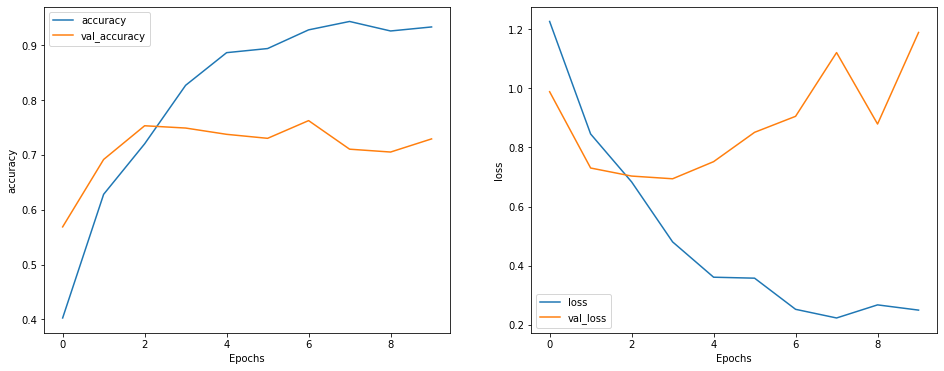

In [125]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
